#**CELL 1 - Setup & Imports**

In [37]:
# ============================================================================
# CELL 1: Setup & Imports
# ============================================================================
"""
IMPETUS_Target_Fix.ipynb - v1.2 (ACWR warm-up + U-shape)
Autore: Alessandro Ambrosio

OBIETTIVO:
1. Calcolare ACWR, performance_score, injury_risk_score dal dataset Banister (RAW)
2. Definire ACWR con rolling windows 7d/28d e gestire warm-up con flag acwr_valid
3. Injury risk score graduale (U-shape leggera) su scala 0-10

RIFERIMENTO SCIENTIFICO (razionale ACWR):
Gabbett, T. J. (2016) - Training–injury prevention paradox
- Sweet spot ACWR ~ 0.8–1.3
- Danger zone ACWR >= 1.5
"""


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configurazione
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
np.random.seed(42)

print("[OK] Setup completato")
print(f"Pandas: {pd.__version__}, NumPy: {np.__version__}")
print("=" * 80)




[OK] Setup completato
Pandas: 2.2.2, NumPy: 2.0.2


#**CELL 2 - Caricamento Dataset Banister RAW**

In [38]:
# ============================================================================
# CELL 2: Caricamento Dataset Banister RAW
# ============================================================================
"""
Carica dataset RAW dal modello Banister.
"""

DATA_DIR = Path('data/synth_set_level_v2')
banister_path = DATA_DIR / 'banister_daily_sampled.csv'

print(f"Caricamento: {banister_path}")
print("=" * 80)

df_banister = pd.read_csv(banister_path)

print(f"[OK] Dataset caricato: {df_banister.shape[0]:,} righe × {df_banister.shape[1]} colonne\n")
print("COLONNE:")
print(df_banister.columns.tolist())
print()
print("DTYPES:")
print(df_banister.dtypes)
print()
print("PRIME 3 RIGHE:")
print(df_banister.head(3))
print()
print("STATISTICHE BASE:")
print(df_banister[['impulse', 'fitness', 'fatigue', 'performance', 'TSB']].describe())




Caricamento: data/synth_set_level_v2/banister_daily_sampled.csv
[OK] Dataset caricato: 106,571 righe × 11 colonne

COLONNE:
['user_id', 'date', 'impulse', 'tau_F', 'tau_D', 'beta_F', 'beta_D', 'fitness', 'fatigue', 'performance', 'TSB']

DTYPES:
user_id          int64
date            object
impulse        float64
tau_F          float64
tau_D          float64
beta_F         float64
beta_D         float64
fitness        float64
fatigue        float64
performance    float64
TSB            float64
dtype: object

PRIME 3 RIGHE:
   user_id        date  impulse      tau_F     tau_D  beta_F  beta_D  \
0        2  2025-06-10  1154.05  45.802647  5.735083    0.01   0.015   
1        2  2025-06-12     0.00  45.802647  5.735083    0.01   0.015   
2        2  2025-06-14     0.00  45.802647  5.735083    0.01   0.015   

     fitness    fatigue  performance       TSB  
0  11.540500  17.310750     0.000000 -5.770250  
1  11.291269  14.540856     0.916778 -3.249586  
2  11.047421  12.214172     1.67431

#**CELL 3 - Calcolo ACWR**

In [39]:
# ============================================================================
# CELL 3 (FIX): Calcolo ACWR + flag acwr_valid (warm-up handling)
# ============================================================================
"""
ACWR = acute_load (7 giorni) / chronic_load (28 giorni)

Nota: per evitare bias nei primi giorni della serie, ACWR viene considerato valido
solo quando sono disponibili entrambe le rolling windows (acute>=7, chronic>=28).
"""

print("\nCALCOLO ACWR (con warm-up e acwr_valid)")
print("=" * 80)

# ---- Costanti
ACWR_DANGER_THRESHOLD = 1.5  # Gabbett 2016 danger zone

# Prepara date e sort
df_banister['date'] = pd.to_datetime(df_banister['date'])
df_banister = df_banister.sort_values(['user_id', 'date']).reset_index(drop=True)

print("Calcolo rolling windows...")

# Acute load: media impulse 7 giorni (richiede almeno 7 giorni)
df_banister['acute_load'] = df_banister.groupby('user_id')['impulse'].transform(
    lambda x: x.rolling(window=7, min_periods=7).mean()
)

# Chronic load: media impulse 28 giorni (richiede almeno 28 giorni)
df_banister['chronic_load'] = df_banister.groupby('user_id')['impulse'].transform(
    lambda x: x.rolling(window=28, min_periods=28).mean()
)

# Flag validità ACWR
df_banister['acwr_valid'] = df_banister['acute_load'].notna() & df_banister['chronic_load'].notna()

# ACWR: calcolato solo se valido e chronic > 0
df_banister['acwr'] = np.where(
    df_banister['acwr_valid'] & (df_banister['chronic_load'] > 0),
    df_banister['acute_load'] / df_banister['chronic_load'],
    np.nan
)

# Clip outliers estremi (range plausibile)
df_banister['acwr'] = df_banister['acwr'].clip(0.3, 3.0)

# Logging
valid_pct = df_banister['acwr_valid'].mean() * 100
print(f"[OK] ACWR calcolato (validi: {valid_pct:.1f}% dei giorni)")

acwr_valid_series = df_banister.loc[df_banister['acwr_valid'], 'acwr']
print(f"   Mean (valid): {acwr_valid_series.mean():.3f}")
print(f"   Std  (valid): {acwr_valid_series.std():.3f}")
print(f"   Range(valid): [{acwr_valid_series.min():.3f}, {acwr_valid_series.max():.3f}]")
print()

# Spike analysis (solo giorni validi)
spike = (acwr_valid_series >= ACWR_DANGER_THRESHOLD).sum()
pct_spike = (acwr_valid_series >= ACWR_DANGER_THRESHOLD).mean() * 100
print(f"Spike ACWR >= {ACWR_DANGER_THRESHOLD:.2f} (solo valid): {spike:,} giorni ({pct_spike:.2f}%)")



CALCOLO ACWR (con warm-up e acwr_valid)
Calcolo rolling windows...
[OK] ACWR calcolato (validi: 87.1% dei giorni)
   Mean (valid): 1.030
   Std  (valid): 0.166
   Range(valid): [0.300, 1.974]

Spike ACWR >= 1.50 (solo valid): 476 giorni (0.51%)


#**CELL 4 - Calcolo Performance Score**

In [46]:
# ============================================================================
# CELL 4: Calcolo Performance Score (0-10)
# ============================================================================
"""
Performance score basato su:
- TSB positivo → buona performance
- Fitness alta → buona performance
Scala 0-10.
"""

print("\nCALCOLO PERFORMANCE SCORE")
print("=" * 80)

# Normalizza TSB e fitness (percentili 5-95 per robustezza)
tsb_min, tsb_max = df_banister['TSB'].quantile([0.05, 0.95])
fitness_min, fitness_max = df_banister['fitness'].quantile([0.05, 0.95])

print(f"Range TSB: [{tsb_min:.2f}, {tsb_max:.2f}]")
print(f"Range fitness: [{fitness_min:.2f}, {fitness_max:.2f}]")
print()

# Normalizza a [0, 1]
tsb_norm = ((df_banister['TSB'] - tsb_min) / (tsb_max - tsb_min)).clip(0, 1)
fitness_norm = ((df_banister['fitness'] - fitness_min) / (fitness_max - fitness_min)).clip(0, 1)

# Performance = weighted average (60% TSB, 40% fitness) × 10
df_banister['performance_score_0_10'] = (0.6 * tsb_norm + 0.4 * fitness_norm) * 10

print(f"[OK] Performance score calcolato")
print(f"   Mean: {df_banister['performance_score_0_10'].mean():.2f}")
print(f"   Std: {df_banister['performance_score_0_10'].std():.2f}")
print(f"   Range: [{df_banister['performance_score_0_10'].min():.2f}, {df_banister['performance_score_0_10'].max():.2f}]")

assert 'performance' in df_banister.columns  # 0-100 (Banister)
assert 'performance_score_0_10' in df_banister.columns  # 0-10 (tuo score)




CALCOLO PERFORMANCE SCORE
Range TSB: [8.09, 2497.12]
Range fitness: [98.31, 3482.93]

[OK] Performance score calcolato
   Mean: 3.06
   Std: 2.80
   Range: [0.00, 10.00]


#**CELL 5 - Calcolo Injury Risk Score**

In [41]:
# ============================================================================
# CELL 5 Injury Risk Score (U-shape) + uso di acwr_valid
# ============================================================================
"""
Injury risk (0-10) calcolato in modo graduale, con U-shape leggera:
- ACWR < 0.8: rischio relativo aumenta (underprepared) ma con penalità bassa
- 0.8-1.3: sweet spot
- 1.3-1.5: caution
- >= 1.5: danger zone

Il target viene calcolato SOLO dove acwr_valid=True (evita warm-up bias).
"""

print("\nCALCOLO INJURY RISK SCORE - U-SHAPE (con acwr_valid)")
print("=" * 80)

ACWR_SWEET_LOW = 0.8
ACWR_SWEET_HIGH = 1.3
ACWR_DANGER_THRESHOLD = 1.5  # Gabbett 2016

print("PARAMETRI:")
print(f"   SWEET_LOW:  {ACWR_SWEET_LOW}")
print(f"   SWEET_HIGH: {ACWR_SWEET_HIGH}")
print(f"   DANGER:     {ACWR_DANGER_THRESHOLD}")
print()

def calculate_injury_risk_u_shape(acwr):
    """
    Returns: score 0-10
    """
    if acwr < ACWR_SWEET_LOW:
        # Underprepared: penalità leggera (0..~2.5 se acwr=0.3)
        return (ACWR_SWEET_LOW - acwr) * 5.0
    elif acwr <= ACWR_SWEET_HIGH:
        # Sweet spot: 0..3
        return (acwr - ACWR_SWEET_LOW) * (3.0 / (ACWR_SWEET_HIGH - ACWR_SWEET_LOW))
    elif acwr < ACWR_DANGER_THRESHOLD:
        # Caution: 3..6
        return 3.0 + (acwr - ACWR_SWEET_HIGH) * (3.0 / (ACWR_DANGER_THRESHOLD - ACWR_SWEET_HIGH))
    else:
        # Danger: 6..10 (crescita rapida, poi clip)
        return 6.0 + (acwr - ACWR_DANGER_THRESHOLD) * 8.0

# Inizializza a NaN e compila solo su giorni validi
df_banister['injury_risk_score'] = np.nan
mask = df_banister['acwr_valid']

df_banister.loc[mask, 'injury_risk_score'] = (
    df_banister.loc[mask, 'acwr']
      .apply(calculate_injury_risk_u_shape)
      .clip(0, 10)
)

print("[OK] Injury risk score calcolato (solo giorni validi)")
print(f"[INFO] acwr_valid True: {mask.mean()*100:.1f}% dei giorni")
print()

print("STATISTICHE (solo validi):")
print(df_banister.loc[mask, 'injury_risk_score'].describe())
print()

# (Opzionale) Distribuzione per zone ACWR, solo validi
acwr_v = df_banister.loc[mask, 'acwr']
total_v = len(acwr_v)

zone_u = (acwr_v < ACWR_SWEET_LOW).sum()
zone_s = ((acwr_v >= ACWR_SWEET_LOW) & (acwr_v <= ACWR_SWEET_HIGH)).sum()
zone_c = ((acwr_v > ACWR_SWEET_HIGH) & (acwr_v < ACWR_DANGER_THRESHOLD)).sum()
zone_d = (acwr_v >= ACWR_DANGER_THRESHOLD).sum()

print("DISTRIBUZIONE PER ZONA ACWR (solo validi):")
print(f"   ACWR < {ACWR_SWEET_LOW:.1f} (under): {zone_u:,} ({zone_u/total_v*100:.1f}%)")
print(f"   ACWR {ACWR_SWEET_LOW:.1f}-{ACWR_SWEET_HIGH:.1f} (sweet): {zone_s:,} ({zone_s/total_v*100:.1f}%)")
print(f"   ACWR {ACWR_SWEET_HIGH:.1f}-{ACWR_DANGER_THRESHOLD:.1f} (caution): {zone_c:,} ({zone_c/total_v*100:.1f}%)")
print(f"   ACWR >= {ACWR_DANGER_THRESHOLD:.1f} (danger): {zone_d:,} ({zone_d/total_v*100:.1f}%)")



CALCOLO INJURY RISK SCORE - U-SHAPE (con acwr_valid)
PARAMETRI:
   SWEET_LOW:  0.8
   SWEET_HIGH: 1.3
   DANGER:     1.5

[OK] Injury risk score calcolato (solo giorni validi)
[INFO] acwr_valid True: 87.1% dei giorni

STATISTICHE (solo validi):
count    92834.000000
mean         1.491262
std          0.995005
min          0.000040
25%          0.790921
50%          1.392570
75%          2.001149
max          9.792815
Name: injury_risk_score, dtype: float64

DISTRIBUZIONE PER ZONA ACWR (solo validi):
   ACWR < 0.8 (under): 7,250 (7.8%)
   ACWR 0.8-1.3 (sweet): 80,968 (87.2%)
   ACWR 1.3-1.5 (caution): 4,140 (4.5%)
   ACWR >= 1.5 (danger): 476 (0.5%)


#**CELL 6 - Merge Experience Label**

In [42]:
# ============================================================================
# CELL 6: Merge Experience Label - WITH CLEANUP
# ============================================================================
"""
Merge con users per experience_label.
IMPORTANTE: Drop colonne experience esistenti da merge precedenti.
"""

print("\nMERGE EXPERIENCE LABEL")
print("=" * 80)

# CLEANUP: Rimuovi colonne experience da merge precedenti
cols_to_drop = [col for col in df_banister.columns if 'experience' in col.lower()]

if cols_to_drop:
    print(f"CLEANUP: Rimuovo {len(cols_to_drop)} colonne duplicate:")
    for col in cols_to_drop:
        print(f"   - {col}")
    df_banister = df_banister.drop(columns=cols_to_drop)
    print()

print(f"Colonne df_banister: {df_banister.shape[1]}")

# Carica users
users_path = DATA_DIR / 'users_sampled.csv'
df_users = pd.read_csv(users_path)
print(f"Users: {df_users.shape[0]}")
print()

# Merge
print("Merge su 'user_id'...")
df_banister = df_banister.merge(
    df_users[['user_id', 'experience_label']],
    on='user_id',
    how='left'
)

print(f"[OK] Merge completato: {df_banister.shape}")

# Verifica
if 'experience_label' in df_banister.columns:
    missing = df_banister['experience_label'].isna().sum()
    print(f"   Missing experience: {missing}")

    if missing == 0:
      print("\nDISTRIBUZIONE EXPERIENCE (UTENTI - users_sampled):")
      print(df_users['experience_label'].value_counts())

      print("\nDISTRIBUZIONE EXPERIENCE (UTENTI presenti nel banister post-merge):")
      print(df_banister.groupby('experience_label')['user_id'].nunique())

      # distribuzione per righe-giorno:
      print("\nDISTRIBUZIONE EXPERIENCE (RIGHE-GIORNO, non bilanciata per costruzione):")
      print(df_banister['experience_label'].value_counts(normalize=True).sort_index() * 100)

else:
    print("[ERROR] Colonna experience_label non presente dopo merge!")
    print(f"Colonne disponibili: {df_banister.columns.tolist()}")



MERGE EXPERIENCE LABEL
Colonne df_banister: 17
Users: 510

Merge su 'user_id'...
[OK] Merge completato: (106571, 18)
   Missing experience: 0

DISTRIBUZIONE EXPERIENCE (UTENTI - users_sampled):
experience_label
Beginner        170
Intermediate    170
Advanced        170
Name: count, dtype: int64

DISTRIBUZIONE EXPERIENCE (UTENTI presenti nel banister post-merge):
experience_label
Advanced        170
Beginner        170
Intermediate    170
Name: user_id, dtype: int64

DISTRIBUZIONE EXPERIENCE (RIGHE-GIORNO, non bilanciata per costruzione):
experience_label
Advanced        57.206932
Beginner        12.864663
Intermediate    29.928405
Name: proportion, dtype: float64


#**CELL 7 - VALIDAZIONE 1**

In [43]:
# ============================================================================
# CELL 8 (MODIFICATA): VALIDAZIONE 1 - Distribuzione target (solo acwr_valid)
# ============================================================================
"""
Validazione distribuzione di injury_risk_score sui soli giorni in cui ACWR è valido.
Questo evita bias dovuti alla warm-up window delle rolling windows.
"""

print("\nVALIDAZIONE 1: DISTRIBUZIONE (solo acwr_valid)")
print("=" * 80)

mask = df_banister['acwr_valid'] & df_banister['injury_risk_score'].notna()
s = df_banister.loc[mask, 'injury_risk_score']

print(f"Giorni validi: {mask.sum():,} / {len(df_banister):,} ({mask.mean()*100:.1f}%)\n")

print("STATISTICHE:")
print(s.describe())
print()

# Percentili
print("PERCENTILI:")
for p in [1, 5, 10, 25, 50, 75, 90, 95, 99]:
    print(f"   P{p:2d}: {s.quantile(p/100):.3f}")
print()

# Distribuzione per bins (range 0-10)
bins = [0, 1, 2, 4, 6, 8, 10]
labels = ['0-1', '1-2', '2-4', '4-6', '6-8', '8-10']
risk_bin = pd.cut(s, bins=bins, labels=labels, include_lowest=True)

print("DISTRIBUZIONE PER RANGE (solo validi):")
risk_dist = risk_bin.value_counts(normalize=True).sort_index() * 100
for bin_label, pct in risk_dist.items():
    print(f"   {bin_label}: {pct:5.1f}%")
print()

# Check rapidi (tarabili)
pct_zero = (s == 0).mean() * 100
pct_ten = (s == 10).mean() * 100
std_val = s.std()
pct_nonzero = (s > 0).mean() * 100

print(f"[OK] Risk=0:   {pct_zero:.1f}%")
print(f"[OK] Risk=10:  {pct_ten:.1f}%")
print(f"[OK] Std:     {std_val:.3f}")
print(f"[OK] Risk >0: {pct_nonzero:.1f}%")

# Assert "soft" (non troppo aggressivi, ma utili a intercettare bug)
assert pct_zero < 99.5, f"[ERR] Troppi valori = 0 ({pct_zero:.1f}%)"
assert pct_ten < 1.0, f"[ERR] Troppi valori = 10 ({pct_ten:.1f}%)"
assert std_val > 0.2, f"[ERR] Std troppo bassa ({std_val:.3f})"
assert pct_nonzero > 5, f"[ERR] Troppi pochi giorni con risk>0 ({pct_nonzero:.1f}%)"

print("\n[OK] VALIDAZIONE 1 SUPERATA (solo validi)")



VALIDAZIONE 1: DISTRIBUZIONE (solo acwr_valid)
Giorni validi: 92,834 / 106,571 (87.1%)

STATISTICHE:
count    92834.000000
mean         1.491262
std          0.995005
min          0.000040
25%          0.790921
50%          1.392570
75%          2.001149
max          9.792815
Name: injury_risk_score, dtype: float64

PERCENTILI:
   P 1: 0.034
   P 5: 0.172
   P10: 0.344
   P25: 0.791
   P50: 1.393
   P75: 2.001
   P90: 2.599
   P95: 2.996
   P99: 5.113

DISTRIBUZIONE PER RANGE (solo validi):
   0-1:  33.0%
   1-2:  41.9%
   2-4:  22.7%
   4-6:   1.9%
   6-8:   0.5%
   8-10:   0.0%

[OK] Risk=0:   0.0%
[OK] Risk=10:  0.0%
[OK] Std:     0.995
[OK] Risk >0: 100.0%

[OK] VALIDAZIONE 1 SUPERATA (solo validi)


#**CELL 9 - VALIDAZIONE 2**

In [44]:
# ============================================================================
# CELL 9: VALIDAZIONE 2 - No dipendenza da experience (per-utente)
# ============================================================================
"""
Validazione anti-leakage:
- Evita test a livello riga-giorno (sbilanciato per durata storico)
- Usa aggregazione per utente: mean/std del risk per user, poi confronto per classe
"""

print("\nVALIDAZIONE 2: NO DIPENDENZA EXPERIENCE (per-utente, solo acwr_valid)")
print("=" * 80)

mask = df_banister['acwr_valid'] & df_banister['injury_risk_score'].notna()

# Aggregazione per utente (una riga per user)
df_user_risk = (
    df_banister.loc[mask]
      .groupby(['user_id', 'experience_label'])['injury_risk_score']
      .agg(risk_mean='mean', risk_std='std', n_days='count')
      .reset_index()
)

print(f"Utenti con almeno 1 giorno valido: {df_user_risk['user_id'].nunique():,}\n")

print("RISCHIO PER EXPERIENCE (per-utente):")
summary = df_user_risk.groupby('experience_label')[['risk_mean', 'risk_std', 'n_days']].agg(['count','mean','std','min','max']).round(3)
print(summary)
print()

# Correlazione per-utente (experience ordinal) vs risk_mean
exp_map = {'Beginner': 0, 'Intermediate': 1, 'Advanced': 2}
df_user_risk['exp_numeric'] = df_user_risk['experience_label'].map(exp_map)

corr = df_user_risk[['risk_mean', 'exp_numeric']].corr().iloc[0, 1]
print(f"CORRELATION (per-utente) risk_mean vs experience: {corr:.3f}")

# Soglia più stretta (vuoi quasi-indipendenza, non solo <0.8)
assert abs(corr) < 0.20, f"[!] Correlazione per-utente troppo alta: {corr:.3f}"

# Variabilità per classe (evita target quasi costante)
for exp in ['Beginner', 'Intermediate', 'Advanced']:
    std_exp = df_user_risk[df_user_risk['experience_label'] == exp]['risk_mean'].std()
    assert std_exp > 0.05, f"[!] {exp}: variabilità risk_mean troppo bassa ({std_exp:.3f})"

print("[OK] VALIDAZIONE 2 SUPERATA (per-utente)")



VALIDAZIONE 2: NO DIPENDENZA EXPERIENCE (per-utente, solo acwr_valid)
Utenti con almeno 1 giorno valido: 506

RISCHIO PER EXPERIENCE (per-utente):
                 risk_mean                             risk_std                \
                     count   mean    std    min    max    count   mean    std   
experience_label                                                                
Advanced               170  1.467  0.105  1.140  1.756      170  0.833  0.147   
Beginner               166  1.575  0.423  0.281  3.407      165  1.239  0.460   
Intermediate           170  1.472  0.133  0.945  1.853      170  1.015  0.213   

                               n_days                             
                    min    max  count     mean      std min  max  
experience_label                                                  
Advanced          0.438  1.336    170  331.624  116.550  82  632  
Beginner          0.242  2.576    166   55.139   29.323   1  137  
Intermediate      0.432  1.685

#**CELL 10 - Visualizzazione & Salvataggio**


VISUALIZZAZIONE & ANALISI DISTRIBUZIONE (solo validi)
[INFO] Giorni validi: 92,834 / 106,571 (87.1%)

STATISTICHE DESCRITTIVE (solo validi):
count    92834.000000
mean         1.491262
std          0.995005
min          0.000040
25%          0.790921
50%          1.392570
75%          2.001149
max          9.792815
Name: injury_risk_score, dtype: float64

PERCENTILI (solo validi):
   P 1: 0.034
   P 5: 0.172
   P10: 0.344
   P25: 0.791
   P50: 1.393
   P75: 2.001
   P90: 2.599
   P95: 2.996
   P99: 5.113

DISTRIBUZIONE PER BINS (bins=50, range 0-10):
   Bin edges (primi 10): [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
   Counts (primi 10 bins): [5427, 5476, 5981, 6637, 7140, 7999, 8059, 8246, 7768, 6856]
   Max count: 8246 (bin 7)

DISTRIBUZIONE PER RANGE SIGNIFICATIVI (solo validi):
   ~0 (no risk)        :  2,739 giorni (  3.0%)
   0-1 (very low)      : 27,922 giorni ( 30.1%)
   1-3 (low)           : 57,557 giorni ( 62.0%)
   3-6 (medium)        :  4,140 giorni (  4.5%)
   6-

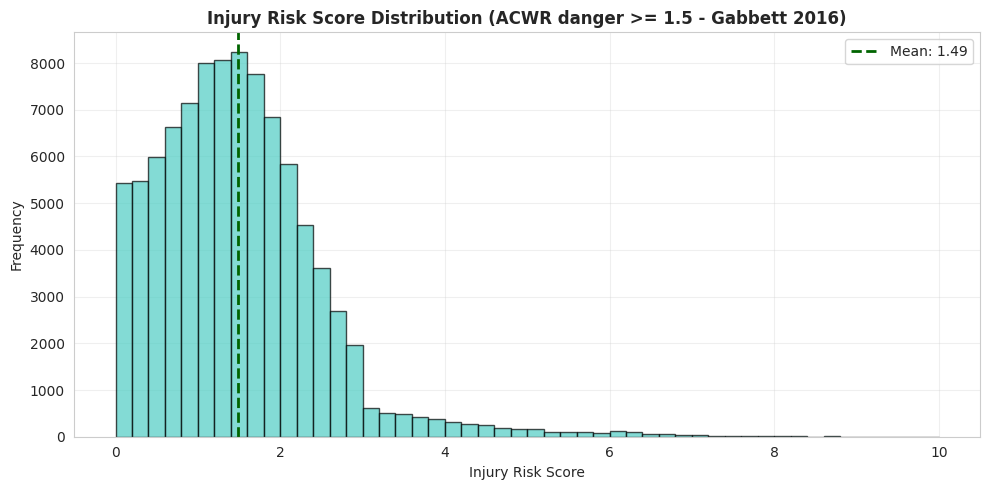

[OK] Visualizzazione salvata: visualizations/IMPETUS_injury_risk_distribution.png
SALVATAGGIO DATASET FIXED
Shape finale: 106,571 x 16

Colonne finali:
    1. user_id
    2. date
    3. impulse
    4. tau_F
    5. tau_D
    6. beta_F
    7. beta_D
    8. fitness
    9. fatigue
   10. performance
   11. TSB
   12. acwr_valid
   13. acwr
   14. performance_score_0_10
   15. injury_risk_score
   16. experience_label

[OK] File salvato: data/synth_set_level_v2/banister_daily_sampled_fixed.csv (21.5 MB)

SAMPLE RIGHE FINALI (prime 3):
   user_id       date  impulse      tau_F     tau_D  beta_F  beta_D    fitness    fatigue  performance       TSB  acwr_valid  acwr  performance_score_0_10  injury_risk_score experience_label
0        2 2025-06-10  1154.05  45.802647  5.735083    0.01   0.015  11.540500  17.310750     0.000000 -5.770250       False   NaN                     0.0                NaN         Beginner
1        2 2025-06-12     0.00  45.802647  5.735083    0.01   0.015  11.291269  14

In [45]:
# ============================================================================
# CELL 10: Visualizzazione & Salvataggio
# ============================================================================
"""
Visualizzazione distribuzione injury_risk finale + salvataggio dataset.
"""

print("\nVISUALIZZAZIONE & ANALISI DISTRIBUZIONE (solo validi)")
print("=" * 80)

mask = df_banister['acwr_valid'] & df_banister['injury_risk_score'].notna()
s = df_banister.loc[mask, 'injury_risk_score']

print(f"[INFO] Giorni validi: {mask.sum():,} / {len(df_banister):,} ({mask.mean()*100:.1f}%)")

print("\nSTATISTICHE DESCRITTIVE (solo validi):")
print(s.describe())
print()

print("PERCENTILI (solo validi):")
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    print(f"   P{p:2d}: {s.quantile(p/100):.3f}")
print()

print("DISTRIBUZIONE PER BINS (bins=50, range 0-10):")
hist_counts, hist_bins = np.histogram(s.values, bins=50, range=(0, 10))
print(f"   Bin edges (primi 10): {hist_bins[:10].round(2).tolist()}")
print(f"   Counts (primi 10 bins): {hist_counts[:10].tolist()}")
print(f"   Max count: {hist_counts.max()} (bin {np.argmax(hist_counts)})")
print()

print("DISTRIBUZIONE PER RANGE SIGNIFICATIVI (solo validi):")
ranges = [
    (0, 0.1, "~0 (no risk)"),
    (0.1, 1, "0-1 (very low)"),
    (1, 3, "1-3 (low)"),
    (3, 6, "3-6 (medium)"),
    (6, 8, "6-8 (high)"),
    (8, 10.1, "8-10 (very high)")
]
for low, high, label in ranges:
    count = ((s >= low) & (s < high)).sum()
    pct = count / len(s) * 100
    print(f"   {label:20s}: {count:6,} giorni ({pct:5.1f}%)")
print()

mean_val = s.mean()
median_val = s.median()
std_val = s.std()
min_val = s.min()
max_val = s.max()

print("VALORI CHIAVE (solo validi):")
print(f"   Mean:   {mean_val:.3f}")
print(f"   Median: {median_val:.3f}")
print(f"   Std:    {std_val:.3f}")
print(f"   Min:    {min_val:.3f}")
print(f"   Max:    {max_val:.3f}")
print()

# PLOT (solo validi)
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(s.values, bins=50, range=(0, 10), color='#4ECDC4', alpha=0.7, edgecolor='black')
ax.axvline(mean_val, color='darkgreen', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
ax.set_title('Injury Risk Score Distribution (ACWR danger >= 1.5 - Gabbett 2016)',
             fontsize=12, fontweight='bold')
ax.set_xlabel('Injury Risk Score')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()

viz_dir = Path('visualizations')
viz_dir.mkdir(exist_ok=True)
plt.savefig(viz_dir / 'IMPETUS_injury_risk_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("[OK] Visualizzazione salvata: visualizations/IMPETUS_injury_risk_distribution.png")


# -------------------------------------------------------------------------
# SALVATAGGIO DATASET
# -------------------------------------------------------------------------
print("SALVATAGGIO DATASET FIXED")
print("=" * 80)

# Drop colonne temporanee
cols_drop = ['acute_load', 'chronic_load', 'risk_bin', 'exp_numeric']
df_final = df_banister.drop(columns=[c for c in cols_drop if c in df_banister.columns])

print(f"Shape finale: {df_final.shape[0]:,} x {df_final.shape[1]}")
print("\nColonne finali:")
for i, col in enumerate(df_final.columns, 1):
    print(f"   {i:2d}. {col}")
print()

output_path = DATA_DIR / 'banister_daily_sampled_fixed.csv'
df_final.to_csv(output_path, index=False)

size_mb = output_path.stat().st_size / (1024**2)
print(f"[OK] File salvato: {output_path} ({size_mb:.1f} MB)")
print()

# Sample righe finali
print("SAMPLE RIGHE FINALI (prime 3):")
print(df_final.head(3).to_string())
print()

print("=" * 80)
print("IMPETUS TARGET FIX COMPLETATO!")
print("=" * 80)
print(f"[OK] ACWR sweet spot: 0.8–1.3; danger zone: >= 1.5 (Gabbett 2016)")
print(f"[OK] Dataset processato: {df_final.shape[0]:,} giorni")
print(f"[OK] Colonne totali: {df_final.shape[1]}")
print(f"[OK] Target calcolati: acwr, performance_score, injury_risk_score")
print(f"[OK] Validazioni: SUPERATE")
print(f"[OK] File output: {output_path}")
print()
print("NEXT STEP: IMPETUS_EDA.ipynb")
